# Human contact networks

Since we now know that the structure of a network can affect the way a disease behaves, the obvious question is exactly what this effect is. A related question, somewhat less abstract, is how this effect manifests itself on a more realistic model of human contacts. If we can develop a model that mimics a "real" social situation, we can get closer to how real epidemics may behave.

Unsurprisingly, modelling human contacts is quite hard. Indeed, there is as yet no scientific consensus on what sorts of networks are the "best" model &ndash; not least because there are lots of different social structures to account for. A city is not just a large village: the ways in which people mix change fundamentally as the geographic and population scales increase, when you no longer know your neighbours and when you travel and mix over a wider area. Even such a simple sentence implies a lot of mathematical complexity. There is less mixing on a small scale with neighbours, but more mixing at longer distances with non-neighbours &ndash; and this is before we consider how friendship networks interrelate, and the effects of disease countermeasures such as social distancing that suddenly became a feature of modern life.

Suffice it to say that the study of contact networks is still an active field of research, being conducted experimentally by the study of real-world social networks as exposed by social media, and theoretically by the study of networks with topological structures that try to reflect how people interact.

While the "right" model is not yet known, we can still make progress by making use of (what we claim is) a better model than the simple ER network, and explore what effects it has. 

## Social structures

A human {index}`contact network` has to model the structures we actually find in human social structures. These structures have been studied extensively  {cite}`Wat99`{cite}`WS98`, and they exhibit huge variation &ndash; far more than we find in, for example, the structure of networks in natural physical and biological systems. This is perhaps due to the diversity of cultural factors that drive social structures, or perhaps because a lot of such networks have been designed for specific purposes rather than simply evolving at random.

```{margin}
"Celebrity" is perhaps more suggestive of what's going on here.
```
One common factor is that the {index}`degree distribution` of a contact network is not {index}`normal <distribution;normal>` (in the mathematical sense) like that of an {ref}`ER network <sec:er-network>`. Instead of the number of contacts clustering around a mean, we tend to observe a small number of nodes who are very highly connected &ndash; far more connected than is possible in an ER network. These people are sometimes referred to as "{index}`hubs`" {cite}`Wat99`. In disease modelling, "{index}`super-spreaders`" might be a better term: individuals who, if they become infected, can potentially infect a huge number of others. This has implications for countermeasures and for vaccination, as we'll see later.

Contact networks often also exagerate factors that are present in the basic mathematics. Pick a node in the network at random, and look at its neighbours: what would you expect *their* degrees to be? It turns out that the degrees of the neighbours of a node chosen at random tend to be greater than that of the node itself. This is because there are more opportunities to connect to a node that has high degree than to one with low degree. In a social setting this means that your friends are typically more popular than you are: they, on average, have more friends than average. This is true of any node chosen at random &ndash; and so, paradoxically, while your friends are on average more popular than you are, *their* friends are also on average more popular than *them*. Clearly this can't be true of everyone in the same network, and is another exmaple of how averaging can mask important detail.

Then there's the issue of randomness. One thing that's obvious about friendship networks is that they tend *not* to be random. If you have two friends, they are *likely* to be friends of each other &ndash; although not *necessarily*, as people often have disjoint sub-sets of friends. Mathematically this manifests itself as **clusters** in the network that are more highly connected that would be expected in a randomly-connected network: in fact it's breathtakingly unlikely for such structures to appear in a randomly-constructed network. Handling this clustering is mathematically very challenging, and forms one of the frontiers of current research {cite}`MMSD20`. Better models will improve the way in which we analyse social networks and improve our understansing of the processes (like diseases) that operate over them.

(sec:hcn-powerlaw)=
## Powerlaw networks

So contact networks have some people who have massively more contacts than others, or than the average. This is taken to an extreme on social media, where a relatively small number of public and celebrity figures have *millions* of "friends". Even though this notion of "friendship" is different to "real" friendship, we see similar effects in physical contact networks: the networks that capture how people interact in the real world. This happens at an individual social level, where some people are natural (or enforced) recluses while others are social butterflies. It also happens through factors like work, where some people &ndash; postal workers, shop cashiers, bus drivers, teachers &ndash; interact with far more people, and far more closely, than do those in other jobs.   

```{raw} latex
   \newpage
```
What {index}`degree distribution` do such networks have? They often follow a {index}`power law <distribution;powerlaw>`, where the probability of a node having a particular degree. $p_k \propto k^{-\alpha}$ for some power $\alpha > 0$. These **{index}`powerlaw <powerlaw network>` networks** {cite}`AB02` describe the structures of networks in a bewildering range of applications: most famously, they describe both the structure of the underlying engineering of the internet and numbers of links to web pages {cite}`YJB02`. These networks are also called **BA networks** after their discoverers, and **scale-free** networks because their large-scale and small-scale structures look the same.

Power-law networks are not *quite* right for contact networks, though, because they can create nodes with really, *really* high degree: too high to appear in human social situations. A variation on the idea was studied by Newman, Watts, and Strogatz {cite}`NWS02` and found to be a better fit. In these networks the power-law degree distribution is "cut off" before it can get too large, essentially setting a ceiling on the number of contacts an individual can have. Unsurprisingly, these networks are known as **{index}`powerlaw with cutoff <powerlaw network;with cutoff>` networks**. 

(sec:hcn-building)=
## Building a contact network

Building a contact network means constructing a network where the nodes have the right degree distribution. In other words, the nodes in the network having degree $k$ appear in the fraction predicted by the degree distribution.

In [2]:
import numpy
import networkx
import epyc
import epydemic
import pandas
import mpmath

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'png'
matplotlib.rcParams['figure.dpi'] = 300
import matplotlib.pyplot as plt
import seaborn
matplotlib.style.use('seaborn')
seaborn.set_context("notebook", font_scale=1.75)

When we {ref}`constructed an ER network <sec:er-building>` we described an algorithm that, when followed, produced a network with the desired distribution. We need a different algorithm to handle different topologies. It turns out that there is a very general algorithm, called the **{index}`configuration model`**, that can construct a random network with *any* degree distribution.

To build a network of size $N$ the configuration model takes a list of $N$ numbers, each describing the degree of a node. It creates nodes with these degrees and wires their edges together randomly. If we can create the degree sequence we want from a degree distribution, we can use the configuration model to build a random network with nodes having those degrees.

We define a function `p()` that, given a degree $k$, returns the probability $p_k$ of a node with that degree appearing in the network. We then define another function to which we provide this function along with the number of nodes we want, and which creates the random network. It repeatedly picks a random degree and then picks a random number betwen 0 and 1. If this second number is less than the probability of a node with that degree occurring, it adds the degree to the sequence; otrherwise it repeats the process for another degree. This continues until we have $N$ node degrees, whih we can then pass to the configuration model to wire together.

In [3]:
def generateFrom(N, p, maxdeg=100):
    # construct degrees according to the distribution given
    # by the model function
    rng = numpy.random.default_rng()
    ns = []
    t = 0
    for i in range(N):
        while True:
            # draw a random degree
            k = rng.integers(1, maxdeg)
            
            # do we include a node with this degree?
            if rng.random() < p(k):
                # yes, add it to the sequence; otherwise,
                # draw again
                ns.append(k)
                t += k
                break

    # the final sequence of degrees has to sum to an even
    # number, as each edge has two endpoints
    # if the sequence is odd, remove an element and draw
    # another from the distribution, repeating until the
    # overall sequence is even
    while t % 2 != 0:
        # pick a node at random
        i = rng.integers(0, len(ns) - 1)

        # remove it from the sequence and from the total
        t -= ns[i]
        del ns[i]
            
        # choose a new node to replace the one we removed
        while True:
            # draw a new degree from the distribution
            k = rng.integers(1, maxdeg)
            
            # do we include a node with this degree?
            if rng.random() < p(k):
                # yes, add it to the sequence; otherwise,
                # draw again
                ns.append(k)
                t += k
                break

    # populate the network using the configuration
    # model with the given degree distribution
    g = networkx.configuration_model(ns,
                                     create_using=networkx.Graph())
    return g

We now need to describe the powerlaw-with-cutoff degree distribution. Mathematically the probability of encountering a node of degree $k$ under this distribution is given by

$$
    p_k \propto k^{-\alpha} e^{-k / \kappa}
$$

Since the distribution is described by two {index}`parameters <parameter>` &ndash; the exponent $\alpha$ and the cutoff $\kappa$ &ndash; we define a function that takes these two parameters and returns a function that returns $p_k$ for any degree $k$.
```{margin}
The number `C` in this function is just a normalising constant needed to make the probabilities for the different degrees sum to 1 so that they form a valid probability distribution.
```

In [4]:
def makePowerlawWithCutoff(alpha, cutoff):
    C = 1.0 / mpmath.polylog(alpha, numpy.exp(-1.0 / cutoff))
    def p(k):
        return (pow((k + 0.0), -alpha) * numpy.exp(-(k + 0.0) / cutoff)) * C
    return p

We can then show the degree distribution that results, by again creating a network and then plotting a histogram of the degrees of the nodes.

In [5]:
# a small sample network
N = 10000
alpha = 2
cutoff = 40

# generate the network from the parameters describing the
# degree distribution
g = generateFrom(N, makePowerlawWithCutoff(alpha, cutoff))

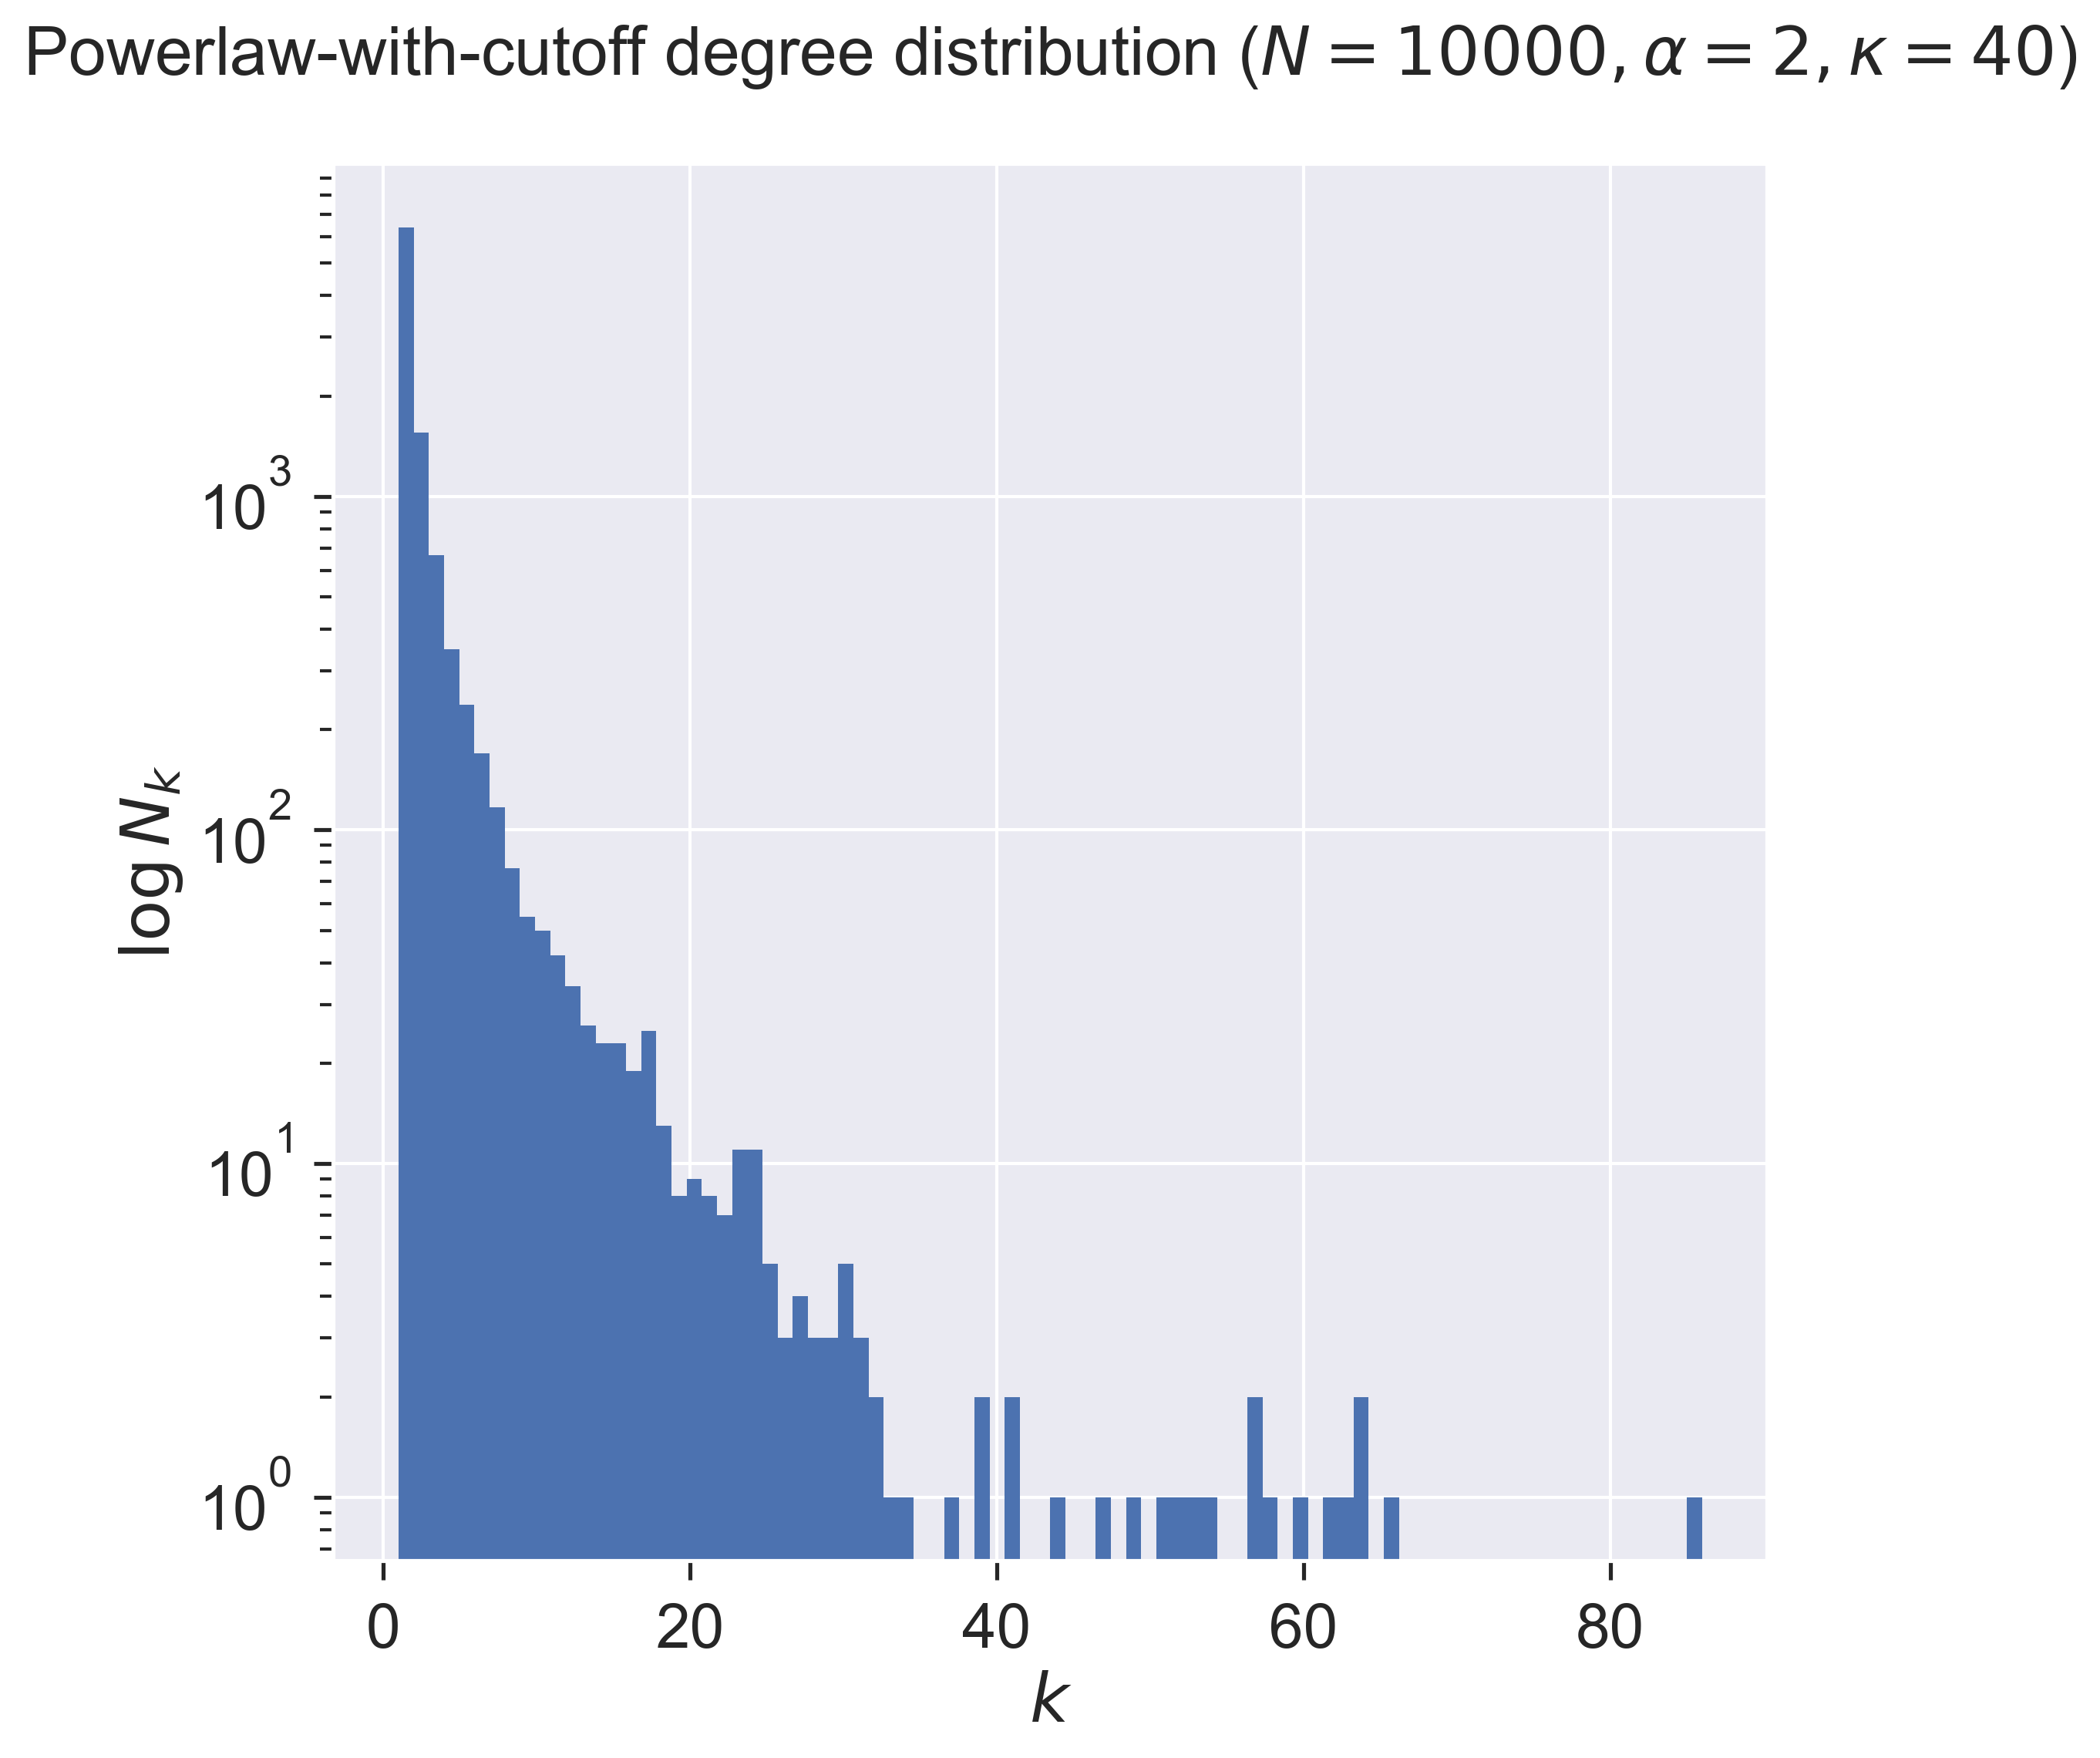

In [6]:
fig = plt.figure(figsize=(8, 8))
ax = fig.gca()

# draw the degree distribution
ks = list(dict(networkx.degree(g)).values())
ax.hist(ks, bins=max(ks))
ax.set_title('Powerlaw-with-cutoff degree distribution ($N = {n}, \\alpha = {e}, \\kappa = {k}$)'.format(n=N, e=alpha, k=cutoff), y=1.05)
ax.semilogy()
ax.set_xlabel('$k$')
ax.set_ylabel('$\\log \\, N_k$')
plt.show()

Notice that the number of nodes falls exponentially until it hits the cutoff (40), after which it becomes very sparse indeed: there are very few nodes with degrees larger than the cutoff value. 

(sec:hcn-spreading)=
## Epidemics spreading on powerlaw networks

Now that we can build a human contact network, we can again run epidemics over it to see what happens: is there an equivalent of the {ref}`epidemic threshold that we saw for ER networks <sec:thresholds-er>`?

Again, we need to conduct some fairly intensive simulation. 

In [ ]:
lab = epyc.ClusterLab(profile='hogun',
                      notebook=epyc.JSONLabNotebook('datasets/threshold-plc.json', create=True))

In [20]:
with lab.sync_imports():
    import time
    import networkx
    import epyc
    import epydemic
    import numpy
    import mpmath
print('{n} engines available'.format(n = lab.numberOfEngines()))

importing time on engine(s)
importing networkx on engine(s)
importing epyc on engine(s)
importing epydemic on engine(s)
importing numpy on engine(s)
importing mpmath on engine(s)
72 engines available


In [7]:
# from https://nbviewer.jupyter.org/gist/minrk/4470122
def pxlocal(line, cell):
    ip = get_ipython()
    ip.run_cell_magic("px", line, cell)
    ip.run_cell(cell)
get_ipython().register_magic_function(pxlocal, "cell")    

We define a class that constructs random-powerlaw-with cutoff networks, essentially just importing the code we developed {ref}`above <sec:hcn-building>` into the simulator.

In [8]:
%%pxlocal

class PLCNetworkDynamics(epydemic.StochasticDynamics):
    
    # Experimental paramerters
    N = 'N'
    ALPHA = 'alpha'
    CUTOFF = 'cutoff'
    
    def __init__(self, p):
        super(PLCNetworkDynamics, self).__init__(p)

    def makePowerlawWithCutoff(self, alpha, cutoff):
        C = 1.0 / mpmath.polylog(alpha, numpy.exp(-1.0 / cutoff))
        def p(k):
            return (pow((k + 0.0), -alpha) * numpy.exp(-(k + 0.0) / cutoff)) * C
        return p
    
    def generatePLC(self, N, alpha, cutoff, maxdeg=100):
        p = self.makePowerlawWithCutoff(alpha, cutoff)
        rng = numpy.random.default_rng()
        ns = []
        t = 0
        for i in range(N):
            while True:
                k = rng.integers(1, maxdeg)
                if rng.random() < p(k):
                    ns.append(k)
                    t += k
                    break
        while t % 2 != 0:
            i = rng.integers(0, len(ns) - 1)
            t -= ns[i]
            del ns[i]
            while True:
                k = rng.integers(1, maxdeg)
                if rng.random() < p(k):
                    ns.append(k)
                    t += k
                    break
        return networkx.configuration_model(ns,
                                            create_using=networkx.Graph())

    def configure(self, params):
        super(PLCNetworkDynamics, self).configure(params)
        
        # build a random powerlaw-with-cutoff network
        # with the given parameters
        N = params[self.N]
        alpha = params[self.ALPHA]
        cutoff = params[self.CUTOFF]
        g = self.generatePLC(N, alpha, cutoff)
        self.setNetworkPrototype(g)

From this we can build a sample network.

In [9]:
N = 10000
alpha = 2
cutoff = 10

And then define a parameter space over which to to run experiments. We run a normal {index}`SIR` process for the range of infection probabilities (values of $p_{\mathit{infect}}$).

In [24]:
# test network
lab[PLCNetworkDynamics.N] = N
lab[PLCNetworkDynamics.ALPHA] = alpha
lab[PLCNetworkDynamics.CUTOFF] = cutoff

# disease parameters
lab[epydemic.SIR.P_INFECTED] = 0.001
lab[epydemic.SIR.P_REMOVE] = 0.002
lab[epydemic.SIR.P_INFECT] = numpy.linspace(0.00001, 1.0,
                                            num=100)

In [25]:
m = epydemic.SIR()
e = PLCNetworkDynamics(m)
rc = lab.runExperiment(epyc.RepeatedExperiment(
                         epyc.RepeatedExperiment(e, 10),
                       10))

In [26]:
lab.readyFraction(), len(lab.dataframe().index)

(1.0, 10000)

Much computation again ensues before we can retrieve the results.

In [10]:
df = epyc.JSONLabNotebook('datasets/threshold-plc.json').dataframe()

Plotting the size of the resulting epidemic as before then yields the folowing:

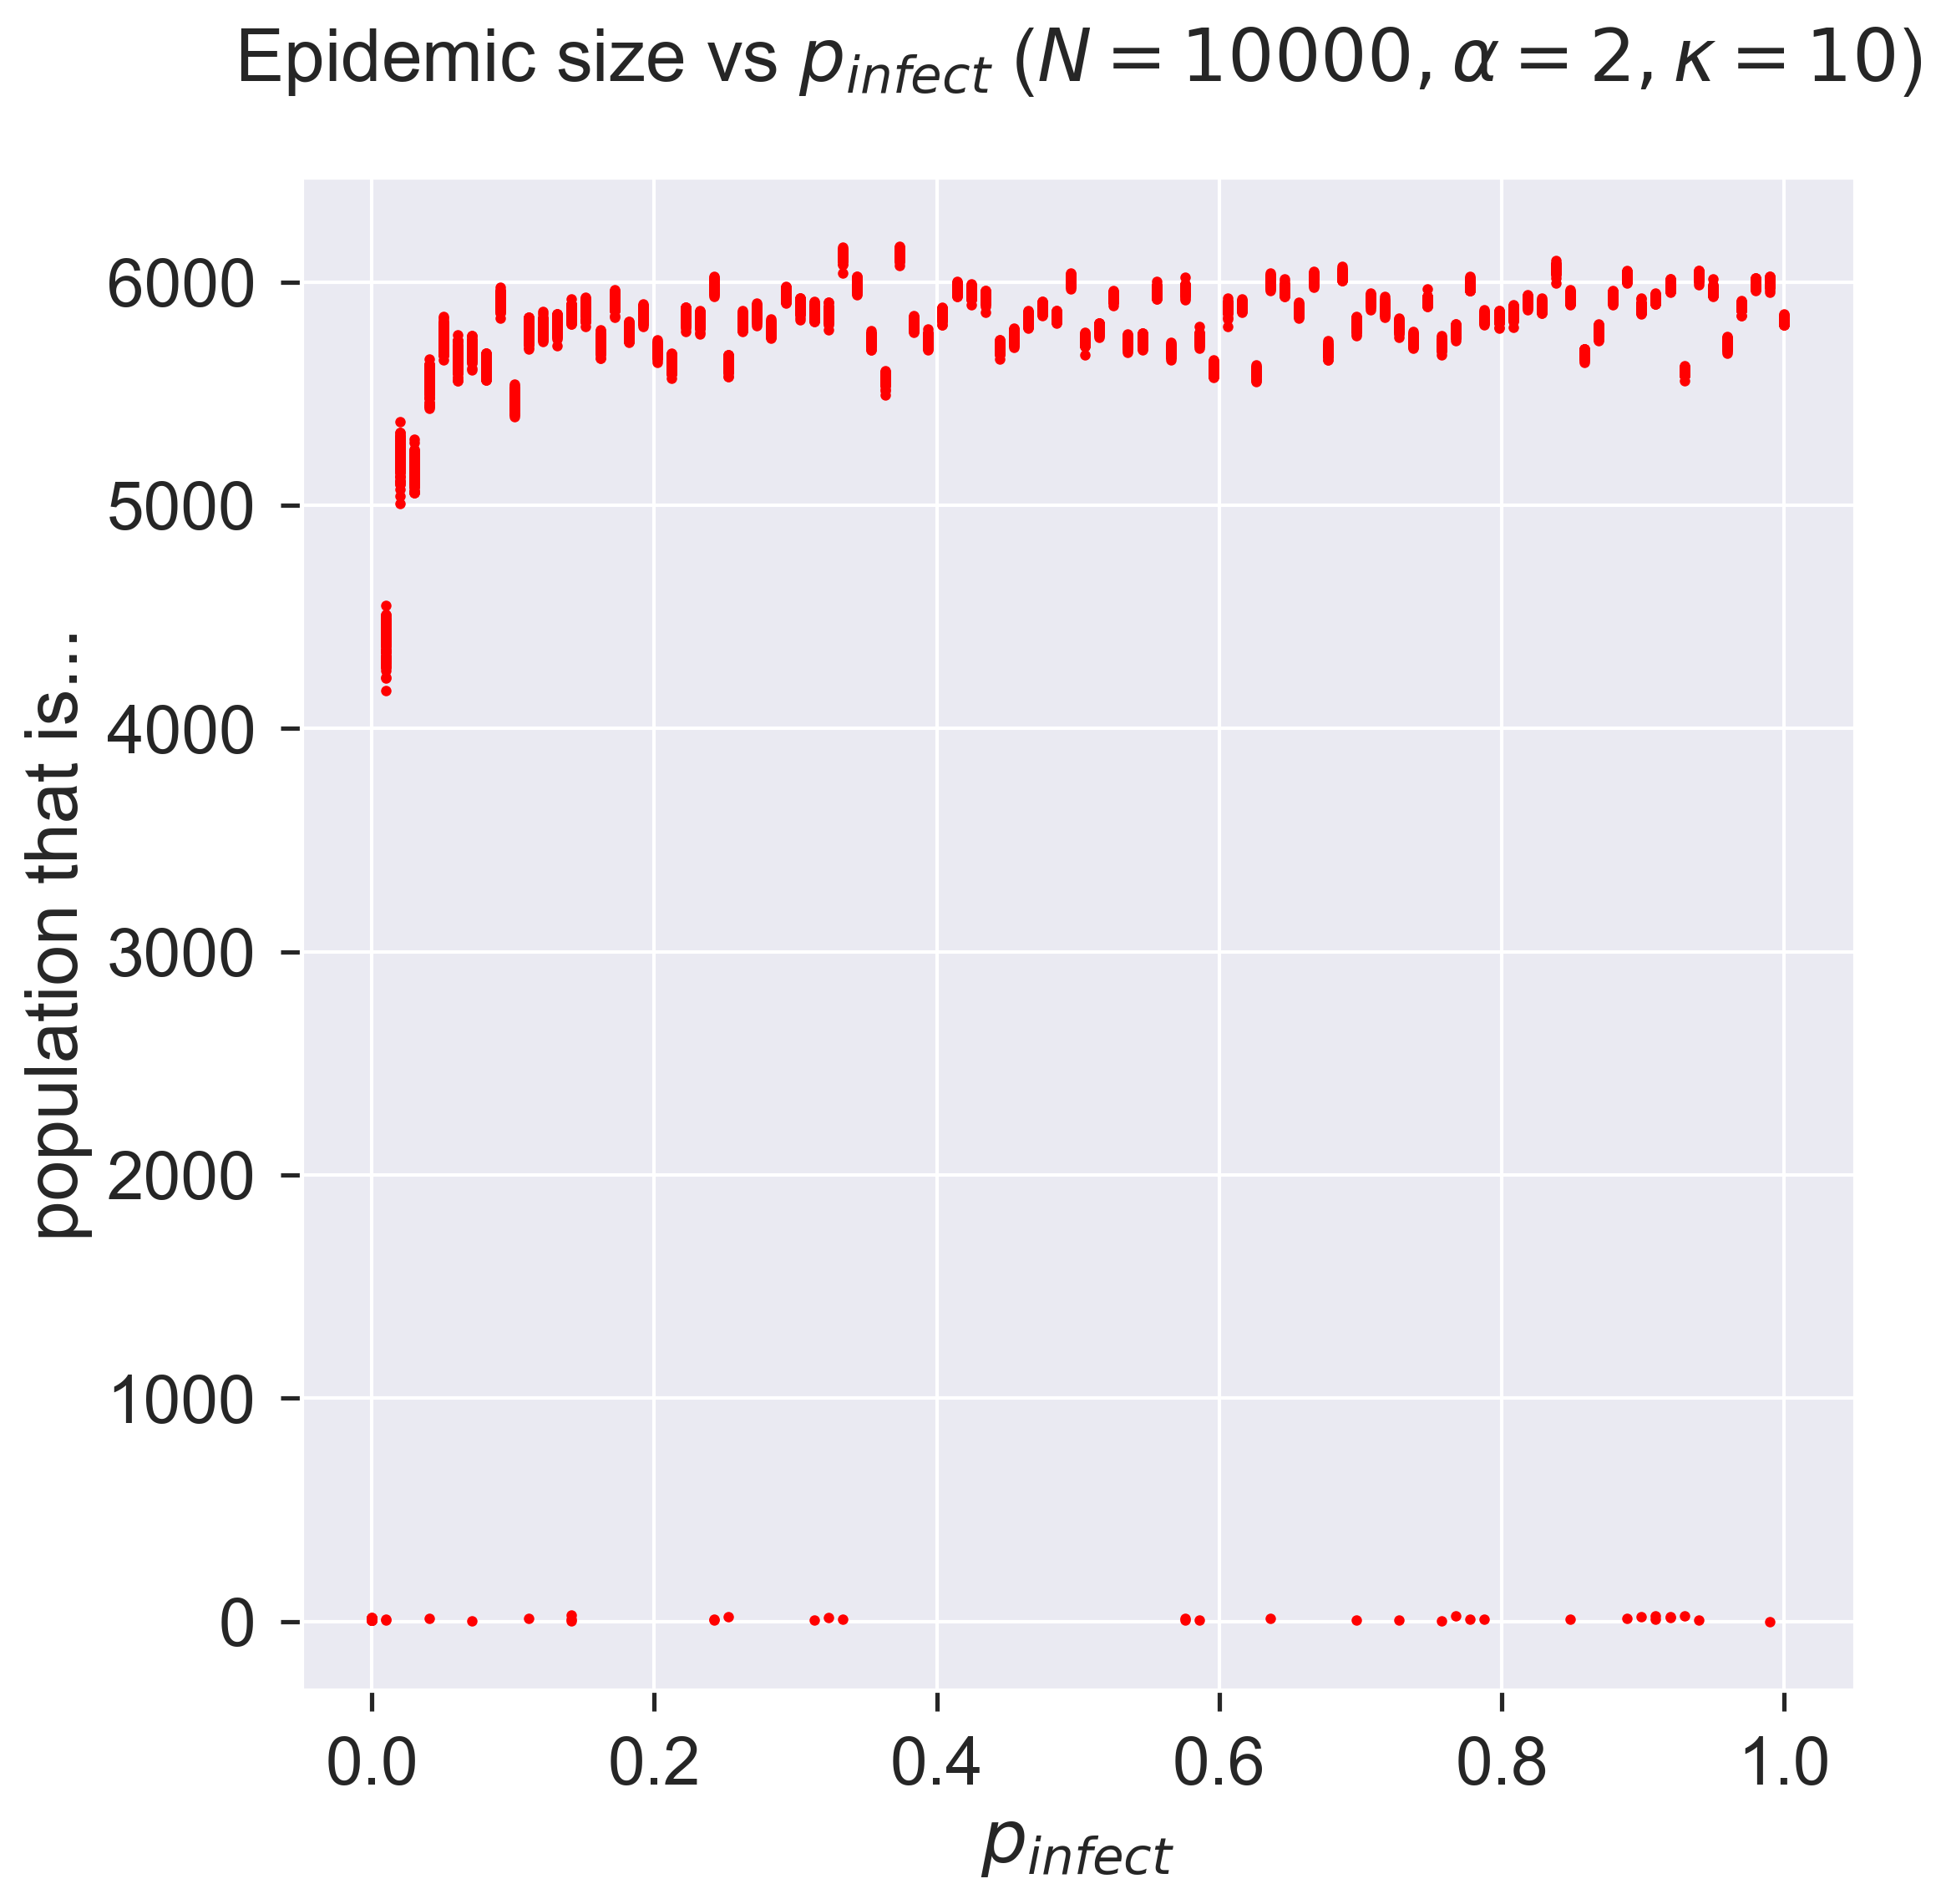

In [11]:
fig = plt.figure(figsize=(8, 8))
ax = fig.gca()

# plot the size of the removed population
cutoffs = df[PLCNetworkDynamics.CUTOFF]
pInfects = df[[kappa == cutoff for kappa in cutoffs]]
ax.plot(pInfects[epydemic.SIR.P_INFECT],
        pInfects[epydemic.SIR.REMOVED], 'r.')
ax.set_xlabel('$p_{\\mathit{infect}}$')
ax.set_ylabel('population that is...')
ax.set_title('Epidemic size vs $p_{\\mathit{infect}}$ ' + '($N = {n}, \\alpha = {a}, \\kappa = {k}$)'.format(n=N, a=alpha, k=cutoff), y=1.05)

plt.show()

Now that's a different result! It seems that, for all values of $p_{\mathit{infect}}$ we can get an epidemic, and with not a lot of variance between the repetitions. This is very much unlike {ref}`the ER network case <sec:thresholds-er>` for which there was a distinct point of infection below which epidemics didn't take hold. Also different is that the size of the epidemic is relatively fixed at about 60% of the population.

If $p_{\mathit{infect}}$ isn't a deciding factor in the emergence of an epidemic, might it depend on the details of the network topology? We can explore this by keeping the disease parameters the same but changing the topological parameters. 

In [12]:
cutoff = 2

In [31]:
lab[PLCNetworkDynamics.CUTOFF] = cutoff
rc = lab.runExperiment(epyc.RepeatedExperiment(epyc.RepeatedExperiment(e, 10), 10))

In [32]:
lab.readyFraction(), len(lab.dataframe().index)

(1.0, 20000)

In [65]:
df = epyc.JSONLabNotebook('datasets/threshold-plc.json').dataframe()

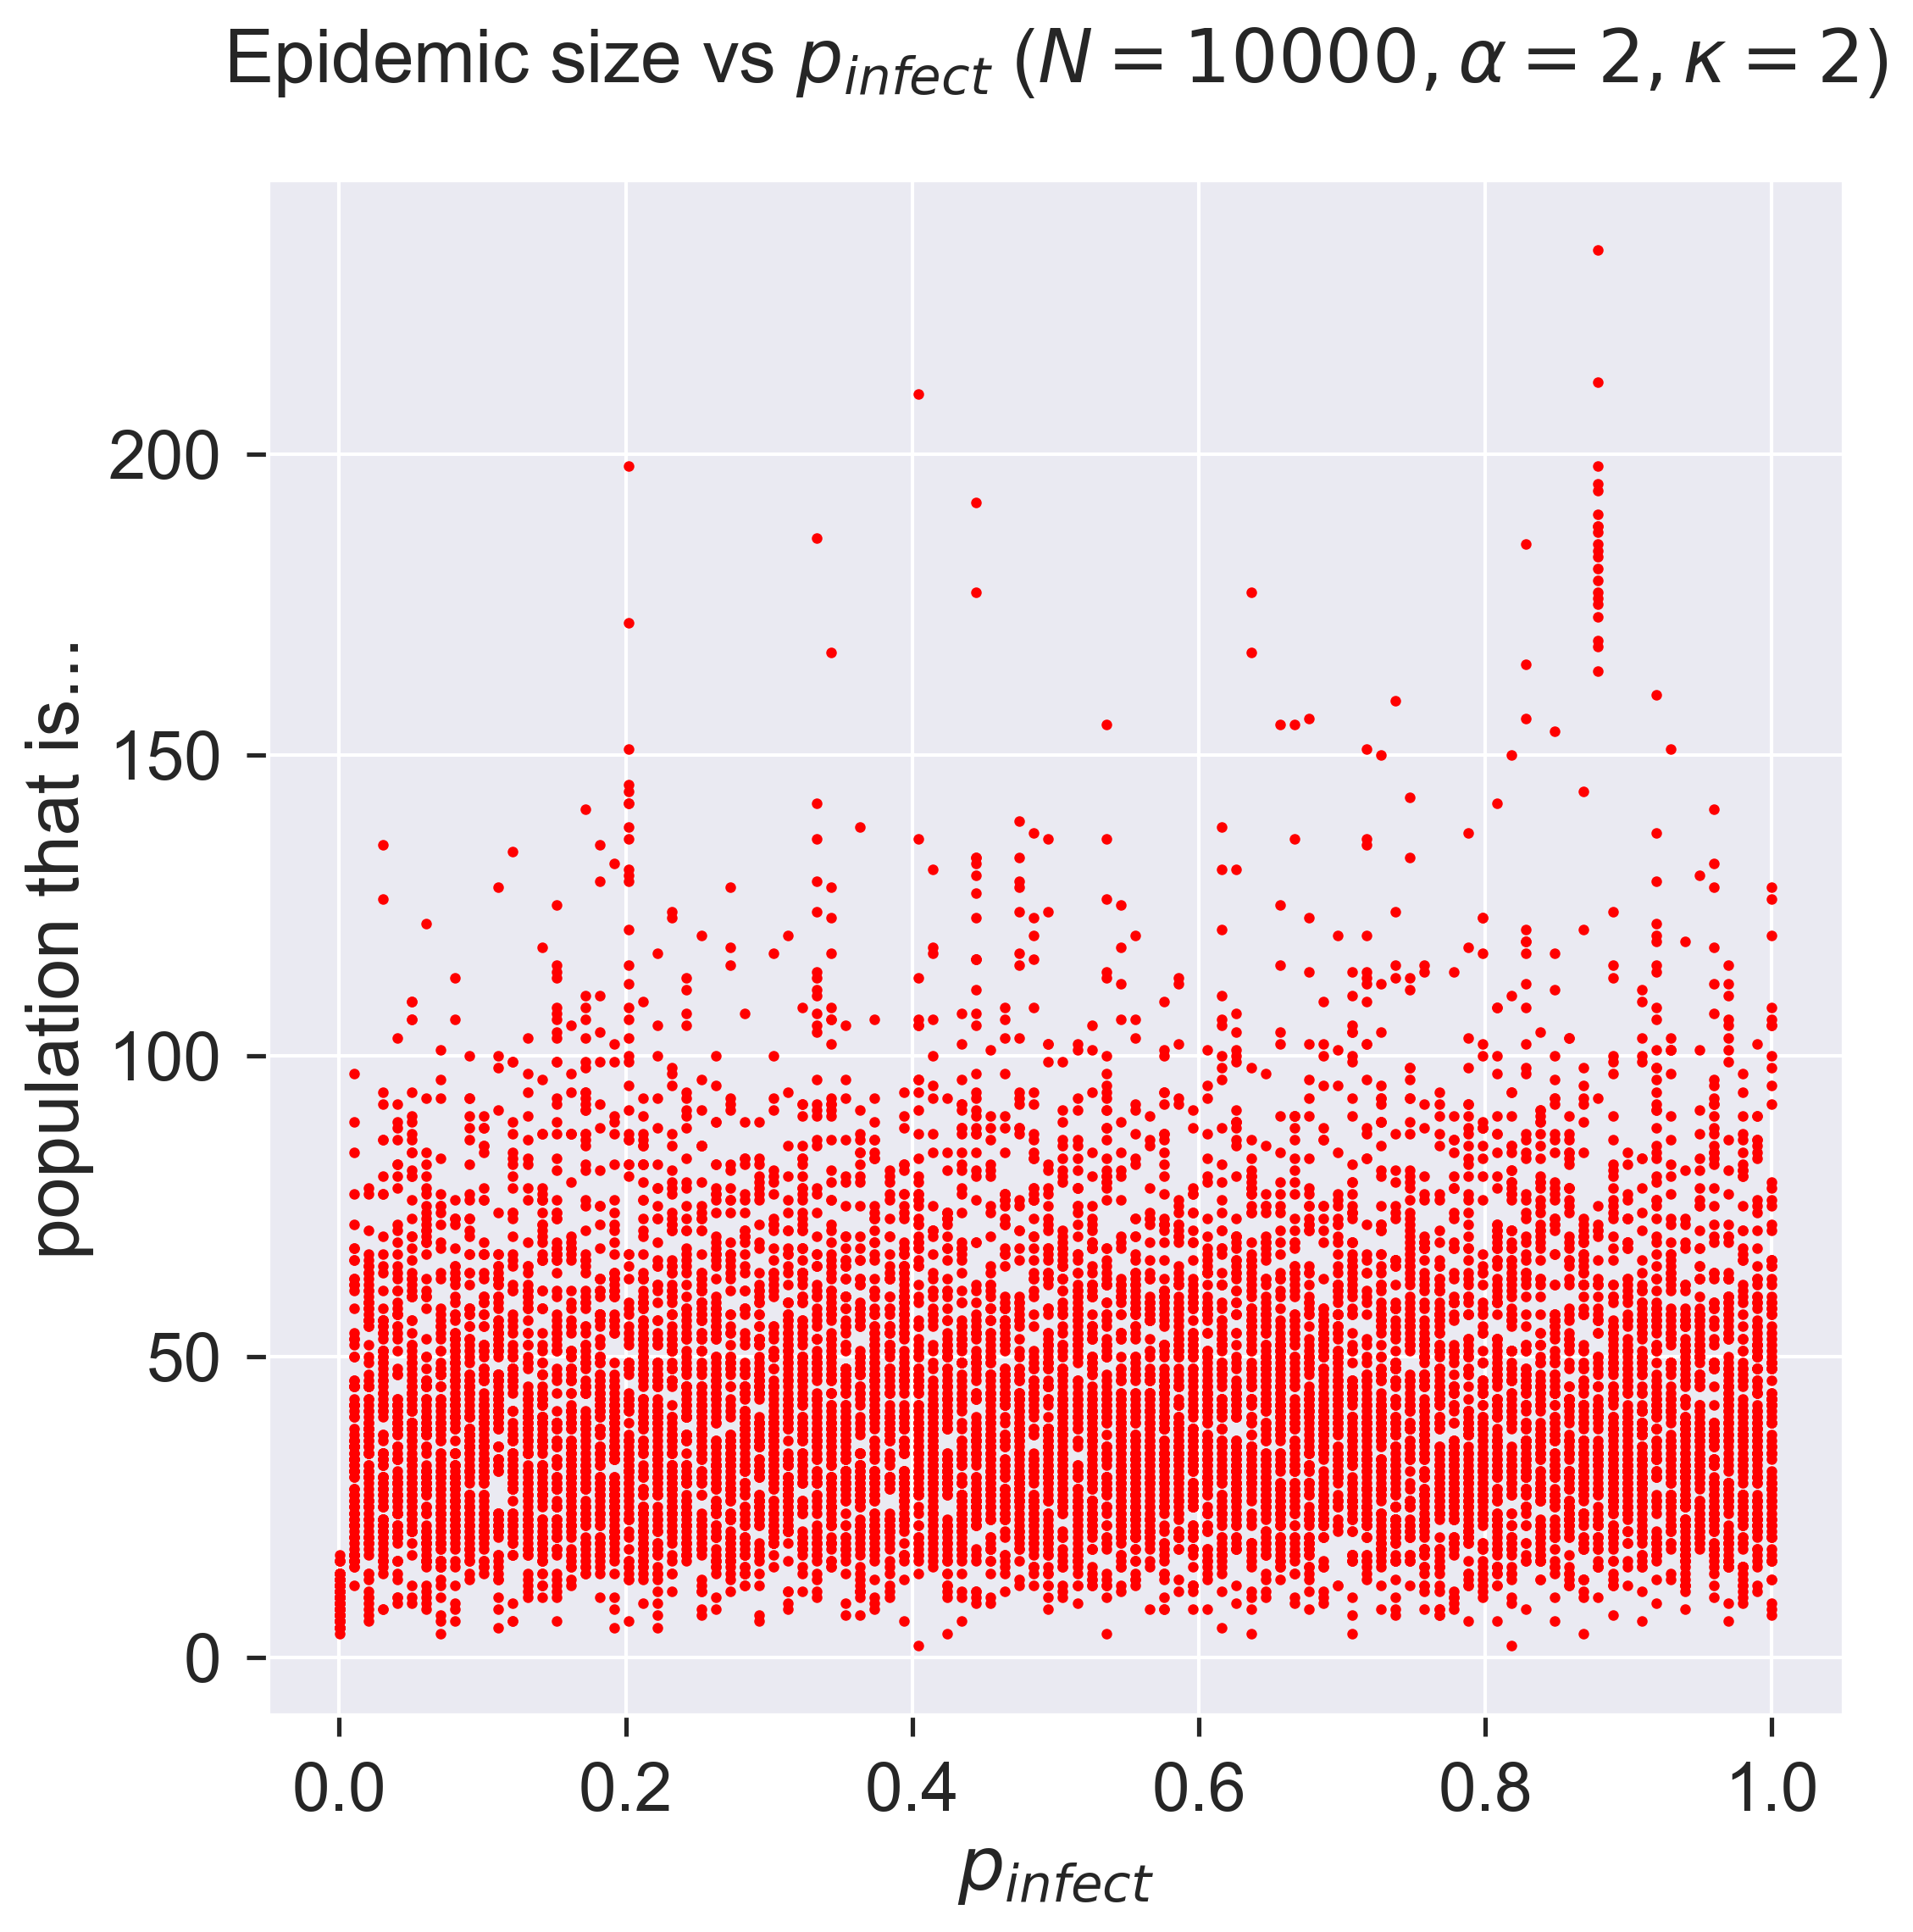

In [13]:
fig = plt.figure(figsize=(8, 8))
ax = fig.gca()

# plot the size of the removed population
cutoffs = df[PLCNetworkDynamics.CUTOFF]
pInfects = df[[kappa == cutoff for kappa in cutoffs]]
ax.plot(pInfects[epydemic.SIR.P_INFECT],
        pInfects[epydemic.SIR.REMOVED], 'r.')
ax.set_xlabel('$p_{\\mathit{infect}}$')
ax.set_ylabel('population that is...')
ax.set_title('Epidemic size vs $p_{\\mathit{infect}}$ ' + '($N = {n}, \\alpha = {a}, \\kappa = {k}$)'.format(n=N, a=alpha, k=cutoff), y=1.05)

plt.show()

For a network with a smaller cutoff, meaning a smaller mean degree for nodes. we still get behaviour that's independent of $p_{\mathit{infect}}$. But look at the range of the y axis: instead of an epidemic through 60% of the population, we get a tiny outbreak affecting less than 5%.

A moment's thought will explain this. The cutoff is so small that the network is extremely sparse -- there are very few edges between nodes -- so it's difficult for the disease to spread. Another way to look at this is that a population with very few social contacts is very safe from diseases spread by contact.

(sec:hcn-always-percolate)=
## The preponderance of epidemics

If we were to explore this phenomenon systematically, we'd discover that it's the value of the exponent and cutoff that control the size of the disease outbreak *not* the infectiousness of the disease. In fact there are two possible regimes for these networks, one in which epidemics *always* affect a large fraction of the population, and one in which they *never* take off {cite}`NWS02`.

```{margin}
The network science community captures this insight with the catchphrase "powerlaw networks always {index}`percolate <percolation>`".
```
From empirical studies it turns out that human contact networks tend to have an exponent of about 2, and for such networks an epidemic will break out for almost *any* value of the cutoff above 2 &ndash; and will *always* break out for powerlaw networks that don't have a cutoff. Put another way, even a small mean number of contacts won't stop an epidemic from spreading through a population, pretty much regardless of the disease's infectiousness. The reason is that the "hubs" of highly connected individuals, if they are infected, become "{index}`super-spreaders`" who disseminate the epidemic widely.

This is a significant result. On the one hand, it's bad news: even minor diseases will be spread, driven by the characterics of the contact network itself. However, on the other hand, it suggests strategies for containment if we reduce the mean degree sufficiently, *or* if we tackle the issue of the hubs acting as super-spreaders. These ideas are the basis of both vaccination and social distancing.

## Questions for discussion

- Think about your friends and neighbours. Who are the "hubs? What makes them so?
- Rumours also spread through social networks: people pass information between each other. Could we model rumour-spreading (or "fake news") as a process over the network? Would it behave like a disease? Why? (Or why not?)